# Herschel Stripe 82 IRAC merging

Both SHELA and SpIES provide IRAC fluxes which have marginally overlapping coverage. We chose which to use here since in order to run in low memory mode we must have one catalogue per band before merging

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
44f1ae0 (Thu Nov 30 18:27:54 2017 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
shela = Table.read("{}/SHELA.fits".format(TMP_DIR))
spies= Table.read("{}/SpIES.fits".format(TMP_DIR))

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones: HSC, VHS, VICS82, UKIDSS-LAS, PanSTARRS, SHELA, SpIES.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### SHELA

In [5]:
master_catalogue = shela
master_catalogue['shela_ra'].name = 'ra'
master_catalogue['shela_dec'].name = 'dec'


## Add SpIES

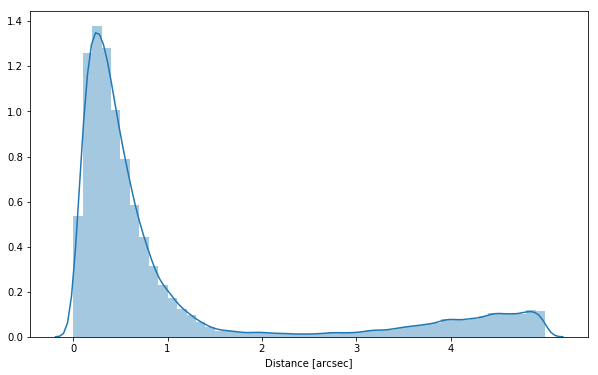

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(spies['spies_ra'], spies['spies_dec'])
)

In [7]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, spies, "spies_ra", "spies_dec", radius=1.5*u.arcsec)
del spies

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [8]:
for col in master_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [9]:
master_catalogue[:10].show_in_notebook()

idx,shela_intid,ra,dec,f_shela_irac1,ferr_shela_irac1,f_ap_shela_irac1,ferr_ap_shela_irac1,f_shela_irac2,ferr_shela_irac2,f_ap_shela_irac2,ferr_ap_shela_irac2,m_shela_irac1,merr_shela_irac1,flag_shela_irac1,m_ap_shela_irac1,merr_ap_shela_irac1,m_shela_irac2,merr_shela_irac2,flag_shela_irac2,m_ap_shela_irac2,merr_ap_shela_irac2,shela_flag_cleaned,shela_flag_gaia,flag_merged,spies_intid,f_ap_spies_irac1,ferr_ap_spies_irac1,f_spies_irac1,ferr_spies_irac1,spies_stellarity_irac1,f_ap_spies_irac2,ferr_ap_spies_irac2,f_spies_irac2,ferr_spies_irac2,spies_stellarity_irac2,m_ap_spies_irac1,merr_ap_spies_irac1,m_spies_irac1,merr_spies_irac1,flag_spies_irac1,m_ap_spies_irac2,merr_ap_spies_irac2,m_spies_irac2,merr_spies_irac2,flag_spies_irac2,spies_flag_cleaned,spies_flag_gaia
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2051282,14.3497916167,0.961694679608,0.465728,0.691827,1.6928,0.480812,2.2341,0.981212,1.80439,0.652208,24.7297,1.61283,False,23.3285,0.308385,23.0272,0.476854,False,23.2592,0.392445,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
1,2050914,14.3505791631,0.960059016932,3.15072,0.864269,2.73617,0.505765,4.49474,1.15394,5.66121,0.690359,22.654,0.297826,False,22.8072,0.200692,22.2682,0.278742,False,22.0177,0.132401,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
2,1107254,14.2593305003,-0.0511404322214,3.10307,1.79801,2.85276,0.525083,6.56224,2.54211,3.02767,0.708096,22.6705,0.629107,False,22.7618,0.199842,21.8574,0.420597,False,22.6972,0.253926,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
3,1985925,14.3825699079,0.890590828022,0.752242,1.47509,1.20344,0.530947,5.90514,1.81347,4.64077,0.683744,24.2091,2.12905,False,23.6989,0.479016,21.9719,0.333431,False,22.2335,0.159966,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
4,1106574,14.2546009134,-0.049770916218,3.35767,1.136,2.63861,0.531049,0.539227,1.59332,2.12192,0.720747,22.5849,0.367337,False,22.8466,0.218516,24.5706,3.20816,False,23.0832,0.368789,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
5,2105673,14.4939441121,1.02178011252,0.798558,0.470993,1.02898,0.533446,2.5592,0.593959,3.57916,0.676669,24.1442,0.640372,False,23.869,0.562872,22.8797,0.251986,False,22.5155,0.205267,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
6,2080939,14.4193031782,0.993783913697,2.26207,0.928799,2.6498,0.540235,3.75859,1.18044,3.90746,0.681168,23.0137,0.4458,False,22.842,0.221358,22.4624,0.340993,False,22.4203,0.189271,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
7,2081956,14.419016466,0.992921647166,3.33556,1.04483,4.11171,0.544713,3.20046,1.39965,5.0543,0.707561,22.5921,0.340097,False,22.3649,0.143836,22.637,0.474823,False,22.1408,0.151994,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0
8,2111783,14.4902358517,1.02805449882,2.6552,0.667202,3.32084,0.545219,3.44337,0.848919,4.39883,0.687474,22.8398,0.272826,False,22.5969,0.178257,22.5575,0.267674,False,22.2917,0.169685,False,0,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0


## III - Merging flags and stellarity

Each pristine catalogue contains a flag indicating if the source was associated to a another nearby source that was removed during the cleaning process.  We merge these flags in a single one.

In [10]:
flag_cleaned_columns = [column for column in master_catalogue.colnames
                        if 'flag_cleaned' in column]

flag_column = np.zeros(len(master_catalogue), dtype=bool)
for column in flag_cleaned_columns:
    flag_column |= master_catalogue[column]
    
master_catalogue.add_column(Column(data=flag_column, name="irac_flag_cleaned"))
master_catalogue.remove_columns(flag_cleaned_columns)

Each pristine catalogue contains a flag indicating the probability of a source being a Gaia object (0: not a Gaia object, 1: possibly, 2: probably, 3: definitely).  We merge these flags taking the highest value.

In [11]:
flag_gaia_columns = [column for column in master_catalogue.colnames
                     if 'flag_gaia' in column]

master_catalogue.add_column(Column(
    data=np.max([master_catalogue[column] for column in flag_gaia_columns], axis=0),
    name="irac_flag_gaia"
))
master_catalogue.remove_columns(flag_gaia_columns)

Each prisitine catalogue may contain one or several stellarity columns indicating the probability (0 to 1) of each source being a star.  We merge these columns taking the highest value.

In [12]:
stellarity_columns = [column for column in master_catalogue.colnames
                      if 'stellarity' in column]

master_catalogue.add_column(Column(
    data=np.nanmax([master_catalogue[column] for column in stellarity_columns], axis=0),
    name="irac_stellarity"
))
master_catalogue.remove_columns(stellarity_columns)

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: All-NaN axis encountered


## VIII - Cross-identification table

We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogue. This can be used to easily get additional information from them.

In [22]:
master_catalogue.add_column(Column(data=(np.char.array(master_catalogue['shela_intid'].astype(str)) 
                                    +  np.char.array(master_catalogue['spies_intid'].astype(str) )), 
                              name="irac_intid"))


In [23]:

id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

['shela_intid', 'spies_intid', 'irac_intid']


In [24]:
#master_catalogue[id_names].write(
#    "{}/master_list_irac_cross_ident_herschel-stripe-82{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

#Lets leave the shela and spies ids in so that the final cross ident table is complete
#master_catalogue.remove_columns(['shela_intid', 'spies_intid'])

## VI - Choosing between multiple values for the same filter

Both SHELA and SpIES provide IRAC1 and IRAC2 fluxes. SpIES seems to go deeper and neither apear to suffer from the bright drop off that affects both SERVS and SWIRE.

In [13]:
seip = Table.read("../../dmu0/dmu0_SEIP/data/SEIP_Herschel-Stripe-82.fits")
seip_coords = SkyCoord(seip['ra'], seip['dec'])
idx, d2d, _ = seip_coords.match_to_catalog_sky(SkyCoord(master_catalogue['ra'], master_catalogue['dec']))
mask = d2d <= 2 * u.arcsec

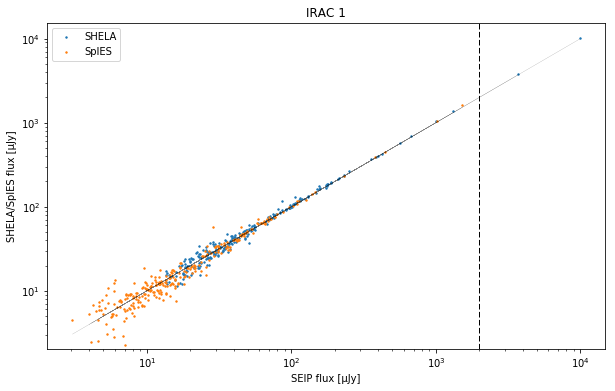

In [14]:
# servs -> shela and swire -> spies
fig, ax = plt.subplots()
ax.scatter(seip['i1_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_shela_irac1'], label="SHELA", s=2.)
ax.scatter(seip['i1_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_spies_irac1'], label="SpIES", s=2.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("SEIP flux [μJy]")
ax.set_ylabel("SHELA/SpIES flux [μJy]")
ax.set_title("IRAC 1")
ax.legend()
ax.axvline(2000, color="black", linestyle="--", linewidth=1.)
ax.plot(seip['i1_f_ap1'][mask], seip['i1_f_ap1'][mask], linewidth=.1, color="black", alpha=.5);

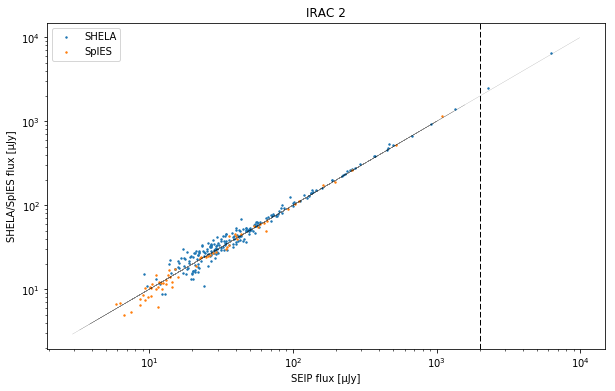

In [15]:
fig, ax = plt.subplots()
ax.scatter(seip['i2_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_shela_irac2'], label="SHELA", s=2.)
ax.scatter(seip['i2_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_spies_irac2'], label="SpIES", s=2.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("SEIP flux [μJy]")
ax.set_ylabel("SHELA/SpIES flux [μJy]")
ax.set_title("IRAC 2")
ax.legend()
ax.axvline(2000, color="black", linestyle="--", linewidth=1.)

ax.plot(seip['i1_f_ap2'][mask], seip['i1_f_ap2'][mask], linewidth=.1, color="black", alpha=.5);

When both SHELA and SpIES fluxes are provided, we use the SpIES flux.

We create a table indicating for each source the origin on the IRAC1 and IRAC2 fluxes that will be saved separately.

In [16]:
irac_origin = Table()
irac_origin.add_column(master_catalogue['irac_intid'])

In [17]:
# IRAC1 aperture flux and magnitudes
has_shela = ~np.isnan(master_catalogue['f_ap_shela_irac1'])
has_spies = ~np.isnan(master_catalogue['f_ap_spies_irac1'])
has_both = has_shela & has_spies

print("{} sources with SHELA flux".format(np.sum(has_shela)))
print("{} sources with SpIES flux".format(np.sum(has_spies)))
print("{} sources with SHELA and SpIES flux".format(np.sum(has_both)))

use_shela = has_shela
use_spies = (has_spies & ~has_shela)

print("{} sources for which we use SHELA".format(np.sum(use_shela)))
print("{} sources for which we use SpIES".format(np.sum(use_spies)))

f_ap_irac = np.full(len(master_catalogue), np.nan)
f_ap_irac[use_shela] = master_catalogue['f_ap_shela_irac1'][use_shela]
f_ap_irac[use_spies] = master_catalogue['f_ap_spies_irac1'][use_spies]

ferr_ap_irac = np.full(len(master_catalogue), np.nan)
ferr_ap_irac[use_shela] = master_catalogue['ferr_ap_shela_irac1'][use_shela]
ferr_ap_irac[use_spies] = master_catalogue['ferr_ap_spies_irac1'][use_spies]

m_ap_irac = np.full(len(master_catalogue), np.nan)
m_ap_irac[use_shela] = master_catalogue['m_ap_shela_irac1'][use_shela]
m_ap_irac[use_spies] = master_catalogue['m_ap_spies_irac1'][use_spies]

merr_ap_irac = np.full(len(master_catalogue), np.nan)
merr_ap_irac[use_shela] = master_catalogue['merr_ap_shela_irac1'][use_shela]
merr_ap_irac[use_spies] = master_catalogue['merr_ap_spies_irac1'][use_spies]

master_catalogue.add_column(Column(data=f_ap_irac, name="f_ap_irac_i1"))
master_catalogue.add_column(Column(data=ferr_ap_irac, name="ferr_ap_irac_i1"))
master_catalogue.add_column(Column(data=m_ap_irac, name="m_ap_irac_i1"))
master_catalogue.add_column(Column(data=merr_ap_irac, name="merr_ap_irac_i1"))

master_catalogue.remove_columns(['f_ap_shela_irac1', 'f_ap_spies_irac1', 
                                 'ferr_ap_shela_irac1', 'ferr_ap_spies_irac1', 
                                 'm_ap_shela_irac1', 'm_ap_spies_irac1',
                                 'merr_ap_shela_irac1', 'merr_ap_spies_irac1'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_shela] = "SHELA"
origin[use_spies] = "SpIES"
irac_origin.add_column(Column(data=origin, name="IRAC1_ap"))

64790 sources with SHELA flux
62528 sources with SpIES flux
20523 sources with SHELA and SpIES flux
64790 sources for which we use SHELA
42005 sources for which we use SpIES


In [18]:
# IRAC1 total flux and magnitudes
has_shela = ~np.isnan(master_catalogue['f_shela_irac1'])
has_spies = ~np.isnan(master_catalogue['f_spies_irac1'])
has_both = has_shela & has_spies

print("{} sources with SHELA total flux".format(np.sum(has_shela)))
print("{} sources with SpIES total flux".format(np.sum(has_spies)))
print("{} sources with SHELA and SpIES total flux".format(np.sum(has_both)))

use_shela = has_shela
use_spies = (has_spies & ~has_shela)

print("{} sources for which we use SHELA".format(np.sum(use_shela)))
print("{} sources for which we use SpIES".format(np.sum(use_spies)))

f_ap_irac = np.full(len(master_catalogue), np.nan)
f_ap_irac[use_shela] = master_catalogue['f_shela_irac1'][use_shela]
f_ap_irac[use_spies] = master_catalogue['f_spies_irac1'][use_spies]

ferr_ap_irac = np.full(len(master_catalogue), np.nan)
ferr_ap_irac[use_shela] = master_catalogue['ferr_shela_irac1'][use_shela]
ferr_ap_irac[use_spies] = master_catalogue['ferr_spies_irac1'][use_spies]

flag_irac = np.full(len(master_catalogue), False, dtype=bool)
flag_irac[use_shela] = master_catalogue['flag_shela_irac1'][use_shela]
flag_irac[use_spies] = master_catalogue['flag_spies_irac1'][use_spies]

m_ap_irac = np.full(len(master_catalogue), np.nan)
m_ap_irac[use_shela] = master_catalogue['m_shela_irac1'][use_shela]
m_ap_irac[use_spies] = master_catalogue['m_spies_irac1'][use_spies]

merr_ap_irac = np.full(len(master_catalogue), np.nan)
merr_ap_irac[use_shela] = master_catalogue['merr_shela_irac1'][use_shela]
merr_ap_irac[use_spies] = master_catalogue['merr_spies_irac1'][use_spies]

master_catalogue.add_column(Column(data=f_ap_irac, name="f_irac_i1"))
master_catalogue.add_column(Column(data=ferr_ap_irac, name="ferr_irac_i1"))
master_catalogue.add_column(Column(data=m_ap_irac, name="m_irac_i1"))
master_catalogue.add_column(Column(data=merr_ap_irac, name="merr_irac_i1"))
master_catalogue.add_column(Column(data=flag_irac, name="flag_irac_i1"))

master_catalogue.remove_columns(['f_shela_irac1', 'f_spies_irac1', 
                                 'ferr_shela_irac1', 'ferr_spies_irac1', 
                                 'm_shela_irac1', 'm_spies_irac1',
                                 'merr_shela_irac1', 'merr_spies_irac1',
                                'flag_shela_irac1', 'flag_spies_irac1'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_shela] = "SHELA"
origin[use_spies] = "SpIES"
irac_origin.add_column(Column(data=origin, name="IRAC1_total"))

64790 sources with SHELA total flux
62528 sources with SpIES total flux
20523 sources with SHELA and SpIES total flux
64790 sources for which we use SHELA
42005 sources for which we use SpIES


In [19]:
# IRAC2 aperture flux and magnitudes
has_shela = ~np.isnan(master_catalogue['f_ap_shela_irac2'])
has_spies = ~np.isnan(master_catalogue['f_ap_spies_irac2'])
has_both = has_shela & has_spies

print("{} sources with SHELA flux".format(np.sum(has_shela)))
print("{} sources with SpIES flux".format(np.sum(has_spies)))
print("{} sources with SHELA and SpIES flux".format(np.sum(has_both)))

use_shela = has_shela
use_spies = (has_spies & ~has_shela)

print("{} sources for which we use SHELA".format(np.sum(use_shela)))
print("{} sources for which we use SpIES".format(np.sum(use_spies)))

f_ap_irac = np.full(len(master_catalogue), np.nan)
f_ap_irac[use_shela] = master_catalogue['f_ap_shela_irac2'][use_shela]
f_ap_irac[use_spies] = master_catalogue['f_ap_spies_irac2'][use_spies]

ferr_ap_irac = np.full(len(master_catalogue), np.nan)
ferr_ap_irac[use_shela] = master_catalogue['ferr_ap_shela_irac2'][use_shela]
ferr_ap_irac[use_spies] = master_catalogue['ferr_ap_spies_irac2'][use_spies]

m_ap_irac = np.full(len(master_catalogue), np.nan)
m_ap_irac[use_shela] = master_catalogue['m_ap_shela_irac2'][use_shela]
m_ap_irac[use_spies] = master_catalogue['m_ap_spies_irac2'][use_spies]

merr_ap_irac = np.full(len(master_catalogue), np.nan)
merr_ap_irac[use_shela] = master_catalogue['merr_ap_shela_irac2'][use_shela]
merr_ap_irac[use_spies] = master_catalogue['merr_ap_spies_irac2'][use_spies]

master_catalogue.add_column(Column(data=f_ap_irac, name="f_ap_irac_i2"))
master_catalogue.add_column(Column(data=ferr_ap_irac, name="ferr_ap_irac_i2"))
master_catalogue.add_column(Column(data=m_ap_irac, name="m_ap_irac_i2"))
master_catalogue.add_column(Column(data=merr_ap_irac, name="merr_ap_irac_i2"))

master_catalogue.remove_columns(['f_ap_shela_irac2', 'f_ap_spies_irac2', 
                                 'ferr_ap_shela_irac2', 'ferr_ap_spies_irac2', 
                                 'm_ap_shela_irac2', 'm_ap_spies_irac2',
                                 'merr_ap_shela_irac2', 'merr_ap_spies_irac2'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_shela] = "SHELA"
origin[use_spies] = "SpIES"
irac_origin.add_column(Column(data=origin, name="IRAC2_ap"))

67537 sources with SHELA flux
62528 sources with SpIES flux
22955 sources with SHELA and SpIES flux
67537 sources for which we use SHELA
39573 sources for which we use SpIES


In [20]:
# IRAC2 total flux and magnitudes
has_shela = ~np.isnan(master_catalogue['f_shela_irac2'])
has_spies = ~np.isnan(master_catalogue['f_spies_irac2'])
has_both = has_shela & has_spies

print("{} sources with SHELA total flux".format(np.sum(has_shela)))
print("{} sources with SpIES total flux".format(np.sum(has_spies)))
print("{} sources with SHELA and SpIES total flux".format(np.sum(has_both)))

use_shela = has_shela
use_spies = (has_spies & ~has_shela)

print("{} sources for which we use SHELA".format(np.sum(use_shela)))
print("{} sources for which we use SpIES".format(np.sum(use_spies)))

f_ap_irac = np.full(len(master_catalogue), np.nan)
f_ap_irac[use_shela] = master_catalogue['f_shela_irac2'][use_shela]
f_ap_irac[use_spies] = master_catalogue['f_spies_irac2'][use_spies]

ferr_ap_irac = np.full(len(master_catalogue), np.nan)
ferr_ap_irac[use_shela] = master_catalogue['ferr_shela_irac2'][use_shela]
ferr_ap_irac[use_spies] = master_catalogue['ferr_spies_irac2'][use_spies]

flag_irac = np.full(len(master_catalogue), False, dtype=bool)
flag_irac[use_shela] = master_catalogue['flag_shela_irac2'][use_shela]
flag_irac[use_spies] = master_catalogue['flag_spies_irac2'][use_spies]

m_ap_irac = np.full(len(master_catalogue), np.nan)
m_ap_irac[use_shela] = master_catalogue['m_shela_irac2'][use_shela]
m_ap_irac[use_spies] = master_catalogue['m_spies_irac2'][use_spies]

merr_ap_irac = np.full(len(master_catalogue), np.nan)
merr_ap_irac[use_shela] = master_catalogue['merr_shela_irac2'][use_shela]
merr_ap_irac[use_spies] = master_catalogue['merr_spies_irac2'][use_spies]

master_catalogue.add_column(Column(data=f_ap_irac, name="f_irac_i2"))
master_catalogue.add_column(Column(data=ferr_ap_irac, name="ferr_irac_i2"))
master_catalogue.add_column(Column(data=m_ap_irac, name="m_irac_i2"))
master_catalogue.add_column(Column(data=merr_ap_irac, name="merr_irac_i2"))
master_catalogue.add_column(Column(data=flag_irac, name="flag_irac_i2"))

master_catalogue.remove_columns(['f_shela_irac2', 'f_spies_irac2', 
                                 'ferr_shela_irac2', 'ferr_spies_irac2', 
                                 'm_shela_irac2', 'm_spies_irac2',
                                 'merr_shela_irac2', 'merr_spies_irac2',
                                'flag_shela_irac2', 'flag_spies_irac2'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_shela] = "SHELA"
origin[use_spies] = "SpIES"
irac_origin.add_column(Column(data=origin, name="IRAC2_total"))

67537 sources with SHELA total flux
62528 sources with SpIES total flux
22955 sources with SHELA and SpIES total flux
67537 sources for which we use SHELA
39573 sources for which we use SpIES


In [21]:
irac_origin.write("{}/herschel-stripe-82_irac_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite = True)

## IX - Saving the catalogue

In [25]:
master_catalogue.colnames

['shela_intid',
 'ra',
 'dec',
 'flag_merged',
 'spies_intid',
 'irac_flag_cleaned',
 'irac_flag_gaia',
 'irac_stellarity',
 'f_ap_irac_i1',
 'ferr_ap_irac_i1',
 'm_ap_irac_i1',
 'merr_ap_irac_i1',
 'f_irac_i1',
 'ferr_irac_i1',
 'm_irac_i1',
 'merr_irac_i1',
 'flag_irac_i1',
 'f_ap_irac_i2',
 'ferr_ap_irac_i2',
 'm_ap_irac_i2',
 'merr_ap_irac_i2',
 'f_irac_i2',
 'ferr_irac_i2',
 'm_irac_i2',
 'merr_irac_i2',
 'flag_irac_i2',
 'irac_intid']

In [26]:
master_catalogue["ra"].name = "irac_ra"
master_catalogue["dec"].name = "irac_dec"
master_catalogue["flag_merged"].name = "irac_flag_merged"

In [32]:
columns = ["irac_intid", "shela_intid", "spies_intid",
           'irac_ra', 'irac_dec', 'irac_flag_merged',  
           'irac_flag_cleaned',  'irac_flag_gaia', 'irac_stellarity']

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    


In [33]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

Missing columns: set()


In [37]:
master_catalogue[:10].show_in_notebook()

idx,shela_intid,irac_ra,irac_dec,irac_flag_merged,spies_intid,irac_flag_cleaned,irac_flag_gaia,irac_stellarity,f_ap_irac_i1,ferr_ap_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,f_irac_i1,ferr_irac_i1,m_irac_i1,merr_irac_i1,flag_irac_i1,f_ap_irac_i2,ferr_ap_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,f_irac_i2,ferr_irac_i2,m_irac_i2,merr_irac_i2,flag_irac_i2,irac_intid
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,
0,2051282,14.3497916167,0.961694679608,False,-1,False,0,nan,1.69280123711,0.480811774731,23.3284912109,0.308385133743,0.465728461742,0.691826999187,24.7296676636,1.61283159256,False,1.80439436436,0.65220785141,23.2591705322,0.392445057631,2.23409605026,0.981211781502,23.0272445679,0.476853758097,False,2051282-1
1,2050914,14.3505791631,0.960059016932,False,-1,False,0,nan,2.73616528511,0.505764901638,22.8071517944,0.200692266226,3.15072250366,0.864268958569,22.6539764404,0.297826290131,False,5.66121339798,0.690359175205,22.0177230835,0.1324005723,4.49474191666,1.15393900871,22.2682418823,0.278741985559,False,2050914-1
2,1107254,14.2593305003,-0.0511404322214,False,-1,False,0,nan,2.85275697708,0.5250826478,22.7618408203,0.199842199683,3.10307025909,1.79800748825,22.6705245972,0.629106521606,False,3.02767157555,0.708095729351,22.697227478,0.253926217556,6.56224393845,2.54210805893,21.8573684692,0.420596778393,False,1107254-1
3,1985925,14.3825699079,0.890590828022,False,-1,False,0,nan,1.20344221592,0.530946552753,23.6989364624,0.479015856981,0.752241671085,1.47508919239,24.2091064453,2.12904691696,False,4.6407699585,0.6837438941,22.2335281372,0.159966021776,5.9051399231,1.81347489357,21.9719238281,0.333430767059,False,1985925-1
4,1106574,14.2546009134,-0.049770916218,False,-1,False,0,nan,2.63860559464,0.531048536301,22.8465652466,0.218516409397,3.35767173767,1.13600027561,22.5849075317,0.36733686924,False,2.12191796303,0.7207467556,23.0831832886,0.368789374828,0.539226949215,1.59332203865,24.5705718994,3.2081618309,False,1106574-1
5,2105673,14.4939441121,1.02178011252,False,-1,False,0,nan,1.02897584438,0.533446073532,23.8689880371,0.562871992588,0.798558413982,0.47099301219,24.1442337036,0.640371620655,False,3.57916164398,0.676669120789,22.5155487061,0.205267101526,2.5592007637,0.593959152699,22.879737854,0.251986086369,False,2105673-1
6,2080939,14.4193031782,0.993783913697,False,-1,False,0,nan,2.64979624748,0.5402354002,22.8419723511,0.221357837319,2.26207256317,0.928799331188,23.0137329102,0.445799589157,False,3.90746164322,0.681167721748,22.4202651978,0.189270809293,3.75858736038,1.18044435978,22.4624404907,0.340992748737,False,2080939-1
7,2081956,14.419016466,0.992921647166,False,-1,False,0,nan,4.11171388626,0.544712722301,22.364944458,0.143836453557,3.33555984497,1.04483377934,22.5920791626,0.340096980333,False,5.05429983139,0.707560956478,22.1408462524,0.151994258165,3.20046138763,1.39965081215,22.63697052,0.474822640419,False,2081956-1
8,2111783,14.4902358517,1.02805449882,False,-1,False,0,nan,3.32084274292,0.545219421387,22.5968856812,0.178257286549,2.65519571304,0.667202472687,22.8397598267,0.272825777531,False,4.39882707596,0.687474489212,22.2916564941,0.169685199857,3.44337272644,0.84891885519,22.5575408936,0.267674148083,False,2111783-1


In [36]:
master_catalogue[columns].write("{}/IRAC.fits".format(TMP_DIR, SUFFIX), overwrite=True)